# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.models import load_model

# Import Data & Data Cleaning

In [2]:
image_data_path = "/kaggle/input/car-crash-or-collision-prediction-dataset/Compressed/dataset"

exel_data_path = "/kaggle/input/car-crash-or-collision-prediction-dataset/Compressed/dataset_database.xlsx"

In [3]:
exel_data = pd.read_excel(exel_data_path)
exel_data.head()

,subject,collision
0,00001.jpg,n
1,00002.jpg,n
2,00003.jpg,n
3,00004.jpg,n
4,00005.jpg,n


In [4]:
label_dict = {row.iloc[0]: 1 if row.iloc[1] == 'y' else 0 for _, row in exel_data.iterrows()} 

raw_data = []

# Process images
for image in tqdm(os.listdir(image_data_path), desc="Processing Rows", unit="row"):
    image_path = os.path.join(image_data_path, image)
    img = plt.imread(image_path)
    img = cv2.resize(img, (224, 224))
    

    label = label_dict.get(image, None) 
    
    if label is not None:
        raw_data.append([img, label])

Processing Rows: 100%|██████████| 10000/10000 [01:34<00:00, 105.50row/s]


In [5]:
x, y = zip(*raw_data)
X_train = np.array(x)[:7500] / 255.0
X_test = np.array(x)[7500:10000] / 255.0
y_train = np.array(y)[:7500]
y_test = np.array(y)[7500:10000]

In [6]:
# fig, axes = plt.subplots(3, 3, figsize=(9, 9))
# axes = axes.flatten()
# for ax, img, label in zip(axes, X_train, y_train):
#     ax.imshow(img)
#     ax.set_title(label)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

# Data Augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

 # Load Pretrained Model (VGG16)

In [8]:
local_weights_path = '/kaggle/input/sayed/scikitlearn/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=local_weights_path, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model

In [9]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# TRAINING

In [12]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    validation_data=(X_test, y_test),
                    epochs=12,
                    class_weight={0: 1., 1: 2.},
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728776021.774048     517 service.cc:145] XLA service 0x7d21ec00c000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728776021.774097     517 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728776051.844042     517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.6864 - loss: 0.9110 - val_accuracy: 0.8108 - val_loss: 0.4515 - learning_rate: 1.0000e-04
Epoch 2/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7826 - loss: 0.6693 - val_accuracy: 0.8196 - val_loss: 0.4161 - learning_rate: 1.0000e-04
Epoch 3/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8019 - loss: 0.6351 - val_accuracy: 0.8216 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 4/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7972 - loss: 0.6365 - val_accuracy: 0.8192 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 5/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8030 - loss: 0.6214 - val_accuracy: 0.8116 - val_loss: 0.4285 - learning_rate: 1.0000e-04
Epoch 6/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8066 - loss: 0.6162 - val_accuracy: 0.8120 - val_loss: 0.4274 - learning_rate: 1.0000e-04
Epoch 7/12
59/59 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8075 - loss: 0.6

## MODEL LOSS AND ACCURACY

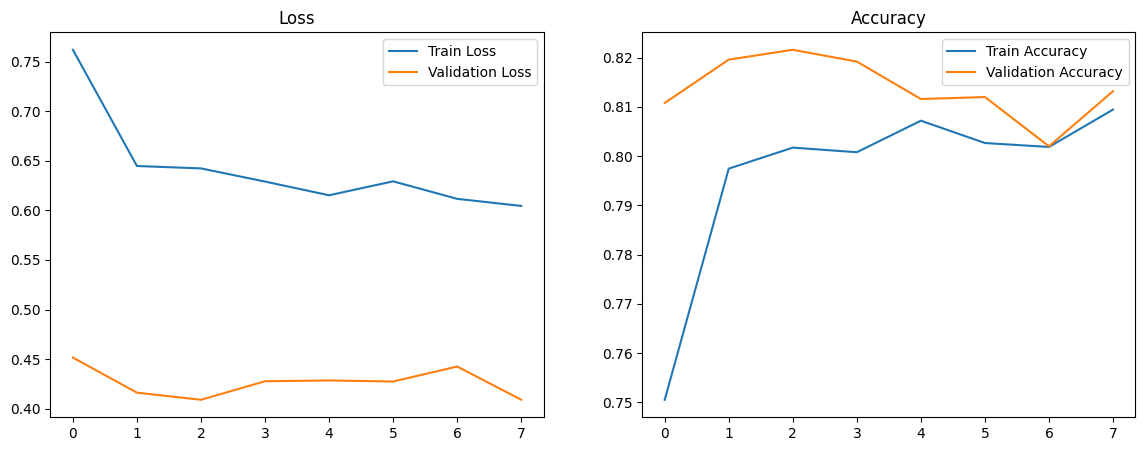

In [14]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

## Y_PRED AND CONF MATRIX

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


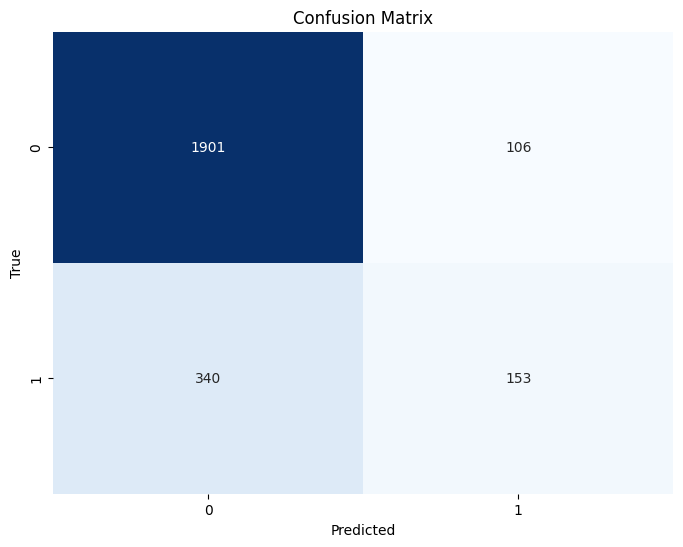

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## MODEL EVALUATE

In [16]:
model.evaluate(X_test, y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8165 - loss: 0.4171


[0.4089725613594055, 0.8216000199317932]

# Model save


In [17]:
model_save_path = "crash_collision_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at crash_collision_model.h5


In [18]:
model1 = load_model('/kaggle/working/crash_collision_model.h5')

In [19]:
model.save('/kaggle/working/crash_car.h5')

In [20]:
from IPython.display import FileLink

# Display a download link
FileLink(r'/kaggle/working/crash_car.h5')


/kaggle/working/crash_car.h5

In [21]:
import os

# List the files in the working directory
print(os.listdir('/kaggle/working/'))


['crash_car.h5', '.virtual_documents', 'crash_collision_model.h5']


In [22]:
model_save_path = "/kaggle/working/crash_collision_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at /kaggle/working/crash_collision_model.h5
